# <font color = "RoyalBlue">Yaklaşımlarım</font>

> __<font color = "darkgreen">Feature engineering sonucunda elde ettiğim 270 feature içeren train - test veri setlerini kullanarak oluşturduğum 200 ağaçlık RandomForest modelinin cv skoru 0.7879 ve lb skoru aşağıdaki gibidir:</font>__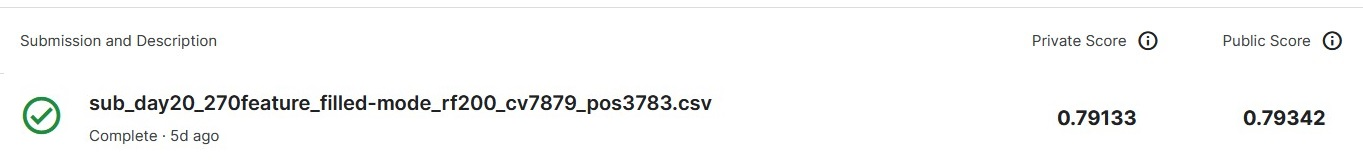


> __<font color = "darkgreen">270 feature içeren train - test veri setlerinde feature selection yaparak boyut küçültmeyi, önemsiz ve modele zarar veren özellikleri tespit ederek modeli iyileştirmeyi ve skorumu artırmayı hedefledim. Bunun sonucunda;</font>__

>> __<font color = "darkgreen">Tüm yetenekler ve tüm dillerin dummy değişken şeklinde olmadığı, 48 featureluk bir alt kümeden oluşan train - test setlerini manuel olarak belirledim. Bu set ile kurulan modelin skorları:</font>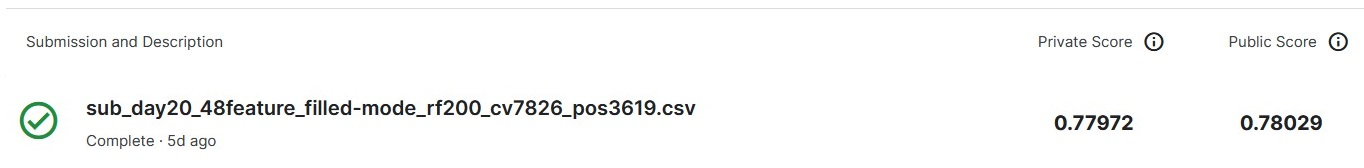<font color = "darkgreen">Yarışma esnasında sadece public skorları görmek mümkünken, bu model bana pozitif sınıfı tahmin etme miktarı azaldığı için ve aynı zamanda leaderboard skoru da daha düşük geldiği için güven vermedi ve bu model ile devam etmedim.</font>__


> __<font color = "darkgreen">RFECV - Recursive Feature Elimination algoritması ile, özelliklerin önemine göre sıralanması ve önemi en düşük özelliklerin silinerek tekrar cv skorunun kontrol edilmesini ve en iyi cv skorunu veren özellikler alt kümesini seçmeyi istedim. Bunun sonucunda 247 feature'dan oluşan bir alt küme ile yeni train - test setlerini oluşturdum. </font>__

> __<font color = "darkgreen">RFECV mantığına benzer bir şekilde fakat bir kaç farklı yönü olan, kendi yazdığım feature_importance_forward_selector fonksiyonu ve düşük varyansa sahip özellikleri veri setinden çıkaran VarianceThreshold metodunu kombine ederek yaptığım feature selection sonucunda 236 feature'dan oluşan bir alt küme ile ek bir train - test seti oluşturdum.</font>__

> __<font color = "royalblue">Finalde 270, 247 ve 236 featureluk setler arasından 270 ve RFE ile 247ye indirgenmiş seti seçmiştim, fakat kendi yöntemimle indirgediğim 236lık setin private skoru RFE ile indirgenen setinkinden daha iyi geldi. Yarışmada 14. olmamı sağlayan set ise 270lik set idi, diğerleriyle beraber skorları şu şekilde: </font>__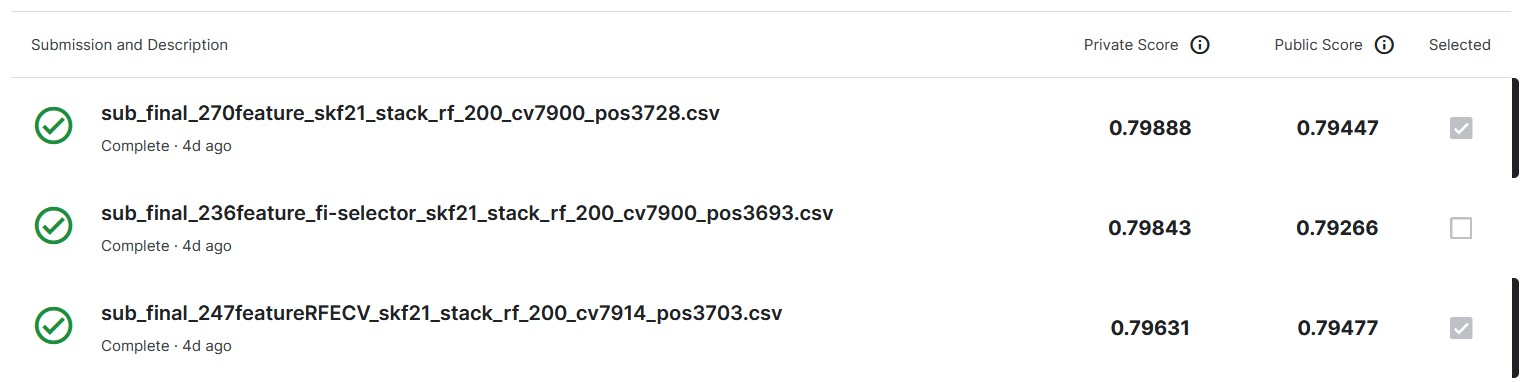


In [1]:
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score ,StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
tqdm.pandas()
import plotly.express as px
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

skf_hp = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

train = pd.read_csv('train270_final.csv')
test = pd.read_csv('test270_final.csv')

x = train.drop(['user_id','moved_after_2019'],axis=1)
y = train.moved_after_2019

__<font color = "darkgreen">Hyperopt ile parametre tuningi yaparken kullanmak üzere 5 splitlik, genel olarak cv yaparken kullanmak üzere 10 splitlik cv nesneleri kurdum</font>__

In [2]:
skf_hp = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

__<font color = "darkgreen">Modelin cv skorunu kontrol etmek ve sonrasında farklı model seed'leri ve farklı cv seed'leri ile modelin sağlamlığını kontrol etmek için yazdığım fonksiyonlar ile gözlemler</font>__

In [3]:
def stratifiedKFold_on_acc(model,x,y,cv):
    start_time = time.time()
    scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1, scoring="accuracy",verbose=24,error_score='raise')
    print("Model : {}".format(model))
    print("scores",scores)
    print(f"scores mean: {np.mean(scores)} ,scores std :{np.std(scores)}" )
    print("\n\n")
    end_time = time.time()
    total_time = end_time - start_time
    print("Total time taken: {} seconds".format(total_time))

def stratifiedKFold_on_acc1(model,x,y,cv):
    start_time = time.time()
    scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1, scoring="accuracy",verbose=0,error_score='raise')
    print("Model : {}".format(model))
    print("scores",scores)
    print(f"scores mean: {np.mean(scores)} ,scores std :{np.std(scores)}" )
    print("\n\n")
    end_time = time.time()
    total_time = end_time - start_time
    print("Total time taken: {} seconds \n".format(total_time))
    return np.mean(scores)


def cv_seed_check(model,x,y,iteration,randomizer,splits):

    random_seeds = random.sample(range(randomizer), iteration)
    
    cv_means = []
    
    seeds = []
        
    for seed in tqdm(random_seeds):
        
        skf = StratifiedKFold(n_splits=splits,shuffle=True,random_state= seed)
        
        mean_ = stratifiedKFold_on_acc1(model,x,y,skf)
        
        cv_means.append(mean_)
        
        seeds.append(seed)
        
        print(f'CV random_state::: {seed} :::\n\n')
        print('*-*-*-'*20)

    cv_max_index = cv_means.index(max(cv_means))
    
    print(f'Max CV: {cv_means[cv_max_index]}, seed: {seeds[cv_max_index]}')
    print(f'Mean of all CV scores: {np.mean(cv_means)}, std: {np.std(cv_means)}\n')
    
    
def model_seed_check(x,y,iteration,randomizer,splits):

    random_seeds = random.sample(range(randomizer), iteration)
    
    cv_means = []
    
    seeds = []
        
    for seed in tqdm(random_seeds):
        
        model = RandomForestClassifier(n_estimators=200, random_state=seed)
        
        skf = StratifiedKFold(n_splits=splits,shuffle=True,random_state= 24)
        
        mean_ = stratifiedKFold_on_acc1(model,x,y,skf)
        
        cv_means.append(mean_)
        
        seeds.append(seed)
        
        
        print(f'Model random_state::: {seed} :::\n\n')
        print('*-*-*-'*20)
    
    cv_max_index = cv_means.index(max(cv_means))
    
    print(f'Max CV: {cv_means[cv_max_index]}, seed: {seeds[cv_max_index]}')

__<font color = "darkgreen">seed = 24 ayarlı mevcut modelde cv skoru, aynı zamanda kullanılan stratified k fold da seed=24 ayarlı</font>__

In [4]:
model = RandomForestClassifier(n_estimators=200,random_state=24)

stratifiedKFold_on_acc(model,x,y,skf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.2min remaining:   48.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.2min remaining:   31.4s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.2min remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Model : RandomForestClassifier(n_estimators=200, random_state=24)
scores [0.78423237 0.79064504 0.78857035 0.78989061 0.78347793 0.7919653
 0.78555262 0.79479442 0.78347793 0.78645539]
scores mean: 0.787906194933719 ,scores std :0.0036900455806636876



Total time taken: 73.99304366111755 seconds


__<font color = "darkgreen">Farklı rastgele sayılar ile bir kaç deneme daha yaptıktan sonra, çok minimal bir artış olsa da son olarak modelin random seed değeri için 9 seçmeye karar verdim. Bu esnada modelin oldukça stabil olduğunu, farklı seedler ile de çok yakın cv sonuçları elde ettiğini gördüm.</font>__

In [5]:
model_seed_check(x,y,10,24,10)

  0%|          | 0/10 [00:00<?, ?it/s]

Model : RandomForestClassifier(n_estimators=200, random_state=18)
scores [0.78366654 0.78913618 0.78574123 0.7874387  0.78328932 0.79573746
 0.78913618 0.79366277 0.78310072 0.78192794]
scores mean: 0.7872837029033973 ,scores std :0.004434473030703661



Total time taken: 70.98984718322754 seconds 

Model random_state::: 18 :::


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model : RandomForestClassifier(n_estimators=200, random_state=11)
scores [0.78253489 0.78630705 0.78215768 0.79026782 0.78479819 0.79328555
 0.78592984 0.79271973 0.78574123 0.78777589]
scores mean: 0.7871517875498177 ,scores std :0.0036703804325277337



Total time taken: 72.97227764129639 seconds 

Model random_state::: 11 :::


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model : RandomForestClassifier(n_estimators=200, random_state=1)
scores [0.78347793 0.7891361

In [6]:
model = RandomForestClassifier(n_estimators=200,random_state=9)
model

RandomForestClassifier(n_estimators=200, random_state=9)

__<font color = "darkgreen">Benzer şekilde cv random seed'ini değiştirerek de benzer stabiliteyi görmüş oldum ve daha iyi sonuç veren başka cv seed'i elde edemedim, 24 ile devam ettim.</font>__

In [7]:
cv_seed_check(model,x,y,10,24,10)

  0%|          | 0/10 [00:00<?, ?it/s]

Model : RandomForestClassifier(n_estimators=200, random_state=9)
scores [0.78536401 0.77970577 0.7804602  0.78800453 0.79969823 0.79064504
 0.78800453 0.78687288 0.78781592 0.78192794]
scores mean: 0.7868499043368187 ,scores std :0.005489836042894527



Total time taken: 77.47026944160461 seconds 

CV random_state::: 20 :::


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model : RandomForestClassifier(n_estimators=200, random_state=9)
scores [0.79026782 0.77876273 0.7874387  0.78989061 0.77781969 0.79253112
 0.7802716  0.79498303 0.77989438 0.7890964 ]
scores mean: 0.7860956072500359 ,scores std :0.005980437193221717



Total time taken: 76.87009525299072 seconds 

CV random_state::: 17 :::


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model : RandomForestClassifier(n_estimators=200, random_state=9)
scores [0.78442097 0.789702   0.78536

## <font color = "royalblue">Hyperopt ile Hiperparametre Optimizasyonu</font>

```python
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 500, 50)),
    'max_depth': hp.choice('max_depth', [None] + list(np.arange(2, 20))),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 20)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', np.arange(0.0, 0.5,0.1)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None] + list(np.arange(5, 35, 5))),
    'min_impurity_decrease': hp.choice('min_impurity_decrease', np.arange(0.0, 0.5)),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),
    'random_state': 24
}


def objective(params):
    model = RandomForestClassifier(**params)  
    
    cv_results = cross_val_score(model.set_params(**params),
                                 x, y, cv=skf_hp ,scoring='accuracy',n_jobs=-1)
    
    best_acc = np.max(cv_results)
    return {'loss': -best_acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters: ", best)


```
__<font color = "darkgreen">Yukarıdaki gibi büyük bir parametre uzayı ile yaptığım aramalarda da, daha küçük bir uzay ile yaptığım aramalarda da 200 ağaçlık Random Forest modelinden daha iyi bir model elde edemedim. Daha küçük uzaya örnek:</font>__ 
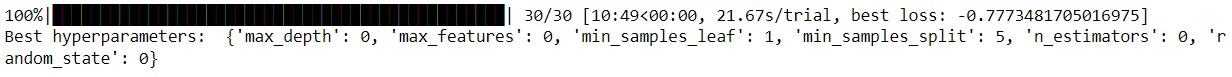


__<font color = "darkgreen">Modeli kompleksleştirmenin yararlı olmadığı sonucunu çıkardım ve en iyi sonucu veren 200 ağaçlık Random Forest ile devam ettim.</font>__


# <font color = "royalblue">CV Training - Stacking</font>

> __<font color = "darkgreen">Random Forest modeli en iyi cv skoruna sahip olduğu için bu modelle ilgilenmeyi final gününe bırakmıştım. Daha öncesinde denediğim ve hiperparametre optimizasyonu yaptığım farklı modellerle ve stacklerle maksimum 0.77 cv skoru ve 0.75 lb skoru elde edebildim. </font>__

> __<font color = "darkgreen">Random Forest modeli tek başına bile gayet stabil ve yüksek cv skoru / lb skoru elde ettiği için , başka model kullanmadan sadece Random Forest modelini stacklemeyi uygun gördüm. Bunu eğitim setini cv için split ederek ve her bir cv splitindeki modeli bir listede tutarak yaptım. </font>__

In [2]:
accuracy = []

models = []

skf = StratifiedKFold(n_splits=21, shuffle=True, random_state=24)

cv_splits = list(skf.split(x, y))

for split_train, split_val in tqdm(cv_splits):
    split_train = x.index[split_train]
    split_val = x.index[split_val]
    
    x_train, y_train = x.loc[split_train], y.loc[split_train]
    x_val, y_val = x.loc[split_val], y.loc[split_val]
    
    print("Train shape:", x_train.shape, "|", "Val Shape:", x_val.shape)
    print("Positive Count in Val Split:", y_val.sum())
    
    
    model = RandomForestClassifier(**{'n_estimators': 200, 'random_state': 9})
    
    model.fit(x_train, y_train)
    
    preds = model.predict(x_val)
    
    acc = accuracy_score(y_val, preds)
    print("Fold Accuracy: ", acc)
    accuracy.append(acc)

    models.append(model)
    
    print("\n", "*-"*50, "\n")
    
print(f'\n Mean Accuracy: {np.mean(accuracy)}, std: {np.std(accuracy)} \n')

  0%|          | 0/21 [00:00<?, ?it/s]

Train shape: (50494, 270) | Val Shape: (2525, 270)
Positive Count in Val Split: 978
Fold Accuracy:  0.7976237623762377

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (50494, 270) | Val Shape: (2525, 270)
Positive Count in Val Split: 978
Fold Accuracy:  0.7710891089108911

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (50494, 270) | Val Shape: (2525, 270)
Positive Count in Val Split: 978
Fold Accuracy:  0.7928712871287129

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (50494, 270) | Val Shape: (2525, 270)
Positive Count in Val Split: 978
Fold Accuracy:  0.7932673267326733

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

Train shape: (50494, 270) | Val Shape: (2525, 270)
Positive Count in Val Split: 978
Fold Accuracy:  0.77

In [9]:
model_preds = [model.predict(test) for model in models]

sub = pd.read_csv('OG_DATA/submission.csv')

sub.moved_after_2019 = (np.mean(model_preds,axis=0)>=0.5).astype(int)

sub.moved_after_2019.value_counts()

0    9527
1    3728
Name: moved_after_2019, dtype: int64

In [12]:
importance = [model.feature_importances_ for model in models]

def plot_stack_feature_importance(importance,names,first_n=5):

    feature_importance = np.mean(importance,axis=0)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'].head(first_n), y=fi_df['feature_names'].head(first_n))
    plt.title(f'STACK FEATURE IMPORTANCE - FIRST {first_n} IMPORTANT FEATURES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

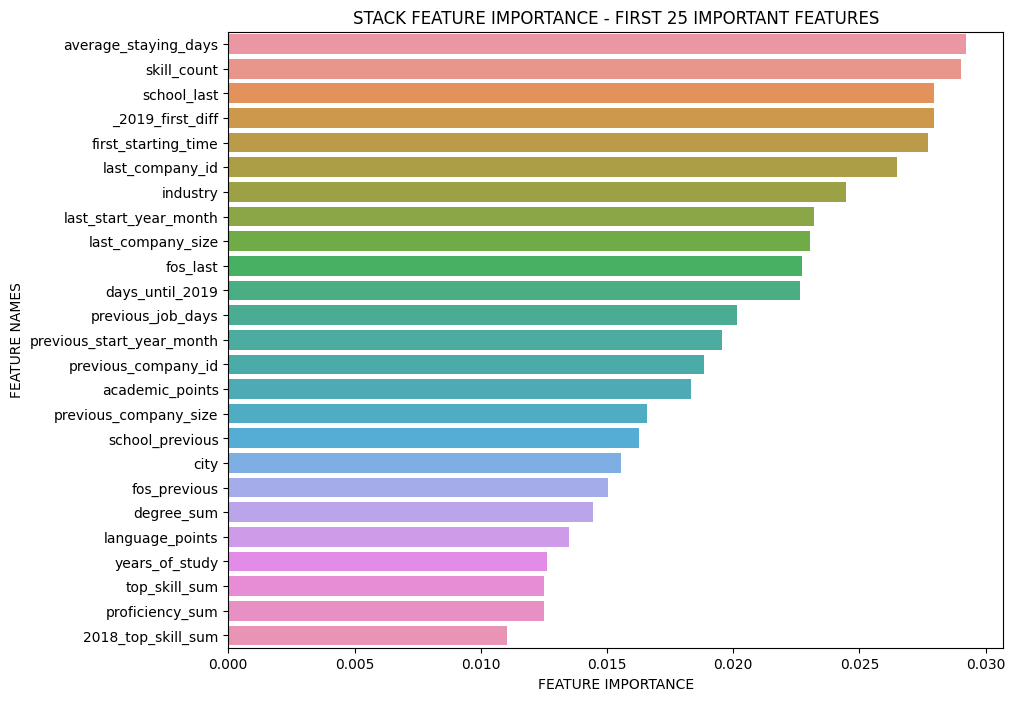

In [13]:
plot_stack_feature_importance(importance,x.columns,25)